In [1]:
print('Start importing required libraries...')
import os, sys, time
import subprocess
sys.path.append('../')
from tqdm.auto import tqdm
import allel
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
torch.autograd.set_detect_anomaly(True)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
from collections import Counter
import gzip
import tagore
from scipy.interpolate import interp1d

from lainet.models.network_constructor import get_network
from lainet.utils.eval import compute_accuracy, AccuracyLogger, complete_sk_eval, print_sk_eval
from lainet.utils.reader import load_founders_from_vcf_and_map, load_results_file
from lainet.utils.output_writer import get_meta_data, write_msp_tsv
from lainet.training import train_main, eval_predictions
from lainet.inference import inference_main 

from utils.format_file import add_result, naming_file, output_name
from utils.format_file import naming_file, extract_from_same_file, extract_from_file,output_name_mixed

print('Done importing')

Start importing required libraries...
Done importing
bcftools has been loaded


In [ ]:

#importing bcftools
exec(open("/shared/software/modules/4.6.1/init/python.py").read(), globals())
module("load", "bcftools")

print("bcftools has been loaded")

In [2]:
# Arguments
genetic_map_file =  "../data/input/real/allchrs_b37.gmap"
config_path = 'configs/default.yaml'

# FORMATING DATA

The first step is to create the file for the train and the test.
if you already have your files you can **skip this section**.

There is three choices, **you only need to chose of the option**: <br>
    1. you want to split only **one file** into the train and test    
    2. you want to use **one file (or a part of ) for the train** and **another file (or a part of) for the test** (the files must have different samples    
    3. you want to **mix samples for one file and another** to do the train and the test

## 1. Extracting train and test from the same file

First let's define some characteristics of our samples. We need to know how many pop, if it's artificial or real and how many sample we want.

In [138]:
nSNP='65k'
pop=['AFR','EUR','EAS','AMR','SAS']
npop=len(pop)


real=True #put true if real, false if artificial


In [139]:
#train
nsamplepop=138

test_file,test_list_file,test_map_file,prefix=naming_file(False,real,nsamplepop,npop,nSNP,'../data/input/')
print(test_file,test_list_file,test_map_file)
print(prefix)

../data/input/real/65k_SNP/5pop_690train.vcf.gz ../data/input/real/65k_SNP/5pop_690train.tsv ../data/input/real/65k_SNP/5pop_690train.smap
../data/input/real/65k_SNP/


In [140]:
#test
nquerypop=209

train_file,train_list_file,train_map_file,prefix=naming_file(True,real,nquerypop,npop,nSNP,'../data/input/')
print(train_file,train_list_file,train_map_file)
print(prefix)

../data/input/real/65k_SNP/5pop_1045test.vcf.gz ../data/input/real/65k_SNP/5pop_1045test.tsv ../data/input/real/65k_SNP/5pop_1045test.smap
../data/input/real/65k_SNP/


In [141]:
reference_file=prefix+'reference.vcf.gz'
reference_map_file=prefix+'reference.smap'
print(reference_file)
print(reference_map_file)

../data/input/real/65k_SNP/reference.vcf.gz
../data/input/real/65k_SNP/reference.smap


In [45]:
extract_from_same_file(reference_file,reference_map_file,nquerypop,nsamplepop,train_map_file,test_map_file,train_list_file,test_list_file,train_file,test_file,pop)

Randomly selecting samples...

{'AFR': 209, 'EUR': 209, 'EAS': 209}
{'AFR': 138, 'EUR': 138, 'EAS': 138}


Running in command line: 
	 bcftools view -S ../data/input/real/65k_SNP/3pop_627test.tsv -Ov -o ../data/input/real/65k_SNP/3pop_627test.vcf.gz ../data/input/real/65k_SNP/reference.vcf.gz 
	 bcftools view -S ../data/input/real/65k_SNP/3pop_414train.tsv -Ov -o ../data/input/real/65k_SNP/3pop_414train.vcf.gz ../data/input/real/65k_SNP/reference.vcf.gz

Done


In [142]:
output_basename=output_name('lainet',nSNP,nsamplepop,nquerypop,pop,real,real)
print(output_basename)

../data/output_lainet/65k_SNP/train690_rAFR-rEUR-rEAS-rAMR-rSAS-test1045_rAFR-rEUR-rEAS-rAMR-rSAS-/


## 2. Extracting train and test from two files

In [93]:
nSNP='65k'
pop=['AFR','EUR','EAS']
npop=len(pop)

In [94]:
#train
real_train=False
nsamplepop=138

train_file,train_list_file,train_map_file,data_folder_s=naming_file(False,real_train,nsamplepop,npop,nSNP,'../data/input/')
print(train_file,train_list_file,train_map_file)
print(data_folder_s)

../data/input/artificial/65k_SNP/3pop_414train.vcf.gz ../data/input/artificial/65k_SNP/3pop_414train.tsv ../data/input/artificial/65k_SNP/3pop_414train.smap
../data/input/artificial/65k_SNP/


In [95]:
#train 
reference_file_s=data_folder_s+'reference.vcf.gz'
reference_map_file_s=data_folder_s+'reference.smap'
print(reference_file_s)
print(reference_map_file_s)

../data/input/artificial/65k_SNP/reference.vcf.gz
../data/input/artificial/65k_SNP/reference.smap


In [96]:
#test
real_test=True
nquerypop=209

test_file,test_list_file,test_map_file,data_folder_q=naming_file(True,real_test,nquerypop,npop,nSNP,'../data/input/')
print(test_file,test_list_file,test_map_file)
print(data_folder_q)

../data/input/real/65k_SNP/3pop_627test.vcf.gz ../data/input/real/65k_SNP/3pop_627test.tsv ../data/input/real/65k_SNP/3pop_627test.smap
../data/input/real/65k_SNP/


In [97]:
#test
reference_file_q=data_folder_q+'reference.vcf.gz'
reference_map_file_q=data_folder_q+'reference.smap'
print(reference_file_q)
print(reference_map_file_q)

../data/input/real/65k_SNP/reference.vcf.gz
../data/input/real/65k_SNP/reference.smap


In [98]:
extract_from_file(reference_file_s,reference_map_file_s,nsamplepop,train_map_file,train_list_file,train_file,pop)

{'AFR': 138, 'EUR': 138, 'EAS': 138}


Running in command line: 
	 bcftools view -S ../data/input/artificial/65k_SNP/3pop_414train.tsv -Ov -o ../data/input/artificial/65k_SNP/3pop_414train.vcf.gz ../data/input/artificial/65k_SNP/reference.vcf.gz
Done


In [99]:
extract_from_file(reference_file_q,reference_map_file_q,nquerypop,test_map_file,test_list_file,test_file,pop)

{'AFR': 209, 'EUR': 209, 'EAS': 209}


Running in command line: 
	 bcftools view -S ../data/input/real/65k_SNP/3pop_627test.tsv -Ov -o ../data/input/real/65k_SNP/3pop_627test.vcf.gz ../data/input/real/65k_SNP/reference.vcf.gz
Done


In [100]:
output_basename=output_name('lainet',nSNP,nsamplepop,nquerypop,pop,real_train,real_test)
print(output_basename)

../data/output_lainet/65k_SNP/train414_aAFR-aEUR-aEAS-test627_rAFR-rEUR-rEAS-/


## 3. Mixing artificial and real genome for the train set

In [3]:
nSNP='65k'
rm=True # if true when merging, old files are removed

First we need to extract real sample and artificial samples into two vcf files and then we will merge those files.

In [27]:
#artificial train set
pop_ta=['EUR']

npop_1=len(pop_ta)
nsamplepop_1=300

train_file,train_list_file,train_map_file,prefix=naming_file(False,False,nsamplepop_1,npop_1,nSNP,'../data/input/')
print("-"*100)

print('ARTIFICIAL TRAIN SET')

print(train_file,train_list_file,train_map_file)
print(prefix)

reference_file=prefix+'reference.vcf.gz'
reference_map_file=prefix+'reference.smap'

extract_from_file(reference_file,reference_map_file,nsamplepop_1,train_map_file,train_list_file,train_file,pop_ta)
print("-"*100)
sfile1=train_file
sfile1_tsv=train_list_file
sfile1_map=train_map_file

----------------------------------------------------------------------------------------------------
ARTIFICIAL TRAIN SET
../data/input/artificial/65k_SNP/1pop_300train.vcf.gz ../data/input/artificial/65k_SNP/1pop_300train.tsv ../data/input/artificial/65k_SNP/1pop_300train.smap
../data/input/artificial/65k_SNP/
{'EUR': 300}


Running in command line: 
	 bcftools view -S ../data/input/artificial/65k_SNP/1pop_300train.tsv -Ov -o ../data/input/artificial/65k_SNP/1pop_300train.vcf.gz ../data/input/artificial/65k_SNP/reference.vcf.gz
Done
----------------------------------------------------------------------------------------------------


In [28]:
#real train set
pop_tr=['AFR','EAS']

npop_2=len(pop_tr)
nsamplepop_2=300

train_file,train_list_file,train_map_file,prefix=naming_file(False,True,nsamplepop_2,npop_2,nSNP,'../data/input/')
print("-"*100)
print('REAL TRAIN SET')

print(train_file,train_list_file,train_map_file)
print(prefix)


#real query set
print("-"*100)
print('REAL QUERY SET1')
nquerypop_1=202

query_file,query_list_file,query_map_file,prefix=naming_file(True,True,nquerypop_1,npop_2,nSNP,'../data/input/')
print(query_file,query_list_file,query_map_file)
print(prefix)

print("-"*100)
reference_file=prefix+'reference.vcf.gz'
reference_map_file=prefix+'reference.smap'
print(reference_file)
print(reference_map_file)

extract_from_same_file(reference_file,reference_map_file,nquerypop_1,nsamplepop_2,train_map_file,query_map_file,train_list_file,query_list_file,train_file,query_file,pop_tr)
print("-"*100)
sfile2=train_file
sfile2_tsv=train_list_file
sfile2_map=train_map_file


qfile1=query_file
qfile1_tsv=query_list_file
qfile1_map=query_map_file

----------------------------------------------------------------------------------------------------
REAL TRAIN SET
../data/input/real/65k_SNP/2pop_600train.vcf.gz ../data/input/real/65k_SNP/2pop_600train.tsv ../data/input/real/65k_SNP/2pop_600train.smap
../data/input/real/65k_SNP/
----------------------------------------------------------------------------------------------------
REAL QUERY SET1
../data/input/real/65k_SNP/2pop_404test.vcf.gz ../data/input/real/65k_SNP/2pop_404test.tsv ../data/input/real/65k_SNP/2pop_404test.smap
../data/input/real/65k_SNP/
----------------------------------------------------------------------------------------------------
../data/input/real/65k_SNP/reference.vcf.gz
../data/input/real/65k_SNP/reference.smap
Randomly selecting samples...

{'AFR': 202, 'EAS': 202}
{'AFR': 300, 'EAS': 300}


Running in command line: 
	 bcftools view -S ../data/input/real/65k_SNP/2pop_600train.tsv -Ov -o ../data/input/real/65k_SNP/2pop_600train.vcf.gz ../data/input/real/65

In [29]:
print('REAL QUERY SET2')
pop_qr=['EUR']
npop=len(pop_qr)
nquerypop_2=202

query_file,query_list_file,query_map_file,prefix=naming_file(True,True,nquerypop_2,npop,nSNP,'../data/input/')

reference_file=prefix+'reference.vcf.gz'
reference_map_file=prefix+'reference.smap'
print(query_file,query_list_file,query_map_file)
print(prefix)

extract_from_file(reference_file,reference_map_file,nquerypop_2,query_map_file,query_list_file,query_file,pop_qr)

print("-"*100)

qfile2=query_file
qfile2_tsv=query_list_file
qfile2_map=query_map_file

REAL QUERY SET2
../data/input/real/65k_SNP/1pop_202test.vcf.gz ../data/input/real/65k_SNP/1pop_202test.tsv ../data/input/real/65k_SNP/1pop_202test.smap
../data/input/real/65k_SNP/
{'EUR': 202}


Running in command line: 
	 bcftools view -S ../data/input/real/65k_SNP/1pop_202test.tsv -Ov -o ../data/input/real/65k_SNP/1pop_202test.vcf.gz ../data/input/real/65k_SNP/reference.vcf.gz
Done
----------------------------------------------------------------------------------------------------


**Now we can merged the train set.**

In [30]:
train_file,base1=output_name_mixed(0,nSNP,True,pop_tr,pop_ta,nsamplepop_1,'../data/input/mixed_set/')
print("-"*100)
print('Creating index for the files')
cmdi1='bcftools index -f '+ sfile1
print("Running in command line: \n\t", cmdi1)
os.system(cmdi1)

print("-"*100)
print('Creating index for the files')
cmdi2='bcftools index -f '+ sfile2
print("Running in command line: \n\t", cmdi2)
os.system(cmdi2)

print("-"*100)
print('Merging')
cmd="bcftools merge "+sfile1 +" "+ sfile2+" -o "+ train_file+ " -O v"
print("Running in command line: \n\t", cmd)
os.system(cmd)
print("-"*100)

print('Done')

----------------------------------------------------------------------------------------------------
Creating index for the files
Running in command line: 
	 bcftools index -f ../data/input/artificial/65k_SNP/1pop_300train.vcf.gz
----------------------------------------------------------------------------------------------------
Creating index for the files
Running in command line: 
	 bcftools index -f ../data/input/real/65k_SNP/2pop_600train.vcf.gz
----------------------------------------------------------------------------------------------------
Merging
Running in command line: 
	 bcftools merge ../data/input/artificial/65k_SNP/1pop_300train.vcf.gz ../data/input/real/65k_SNP/2pop_600train.vcf.gz -o ../data/input/mixed_set/65k_SNP/train900_rAFR-rEAS-aEUR-.vcf.gz -O v
----------------------------------------------------------------------------------------------------
Done


**Merging tsv and smap files too.**

In [31]:
# Read the TSV files into Pandas DataFrames
df1 = pd.read_csv(sfile1_tsv, sep='\t',header=None)
df2 = pd.read_csv(sfile2_tsv, sep='\t',header=None)

# Concat the DataFrames
merged_df = pd.concat([df1, df2],axis=0, ignore_index=True)
# Save the merged DataFrame to a new TSV file
train_list_file,_=output_name_mixed(1,nSNP,True,pop_tr,pop_ta,nsamplepop_1,'../data/input/mixed_set/')
merged_df.to_csv(train_list_file, sep='\t', index=False,header=False)

In [32]:
# Read the map files into Pandas DataFrames
df1 = pd.read_csv(sfile1_map, sep='\t',header=None)
df2 = pd.read_csv(sfile2_map, sep='\t',header=None)

# Concat the DataFrames
merged_df = pd.concat([df1, df2],axis=0, ignore_index=True)
# Save the merged DataFrame to a new smap file
train_map_file,_=output_name_mixed(2,nSNP,True,pop_tr,pop_ta,nsamplepop_1,'../data/input/mixed_set/')
merged_df.to_csv(train_map_file, sep='\t', index=False,header=False)

**Doing the same for the query set**

In [33]:
pop_real=['AFR','EUR','EAS']
pop_artificial=None
test_file,base2=output_name_mixed(0,nSNP,False,pop_real,pop_artificial,nquerypop_1,'../data/input/mixed_set/')

print("-"*100)
print('Creating index for the files')
cmdi1='bcftools index -f '+ qfile1
print("Running in command line: \n\t", cmdi1)
os.system(cmdi1)

print("-"*100)
print('Creating index for the files')
cmdi2='bcftools index -f '+ qfile2
print("Running in command line: \n\t", cmdi2)
os.system(cmdi2)

print("-"*100)
print('Merging')
cmd="bcftools merge "+qfile1 +" "+ qfile2+" -o "+ test_file+ " -O v"
print("Running in command line: \n\t", cmd)
os.system(cmd)
print("-"*100)
print('Done')

----------------------------------------------------------------------------------------------------
Creating index for the files
Running in command line: 
	 bcftools index -f ../data/input/real/65k_SNP/2pop_404test.vcf.gz
----------------------------------------------------------------------------------------------------
Creating index for the files
Running in command line: 
	 bcftools index -f ../data/input/real/65k_SNP/1pop_202test.vcf.gz
----------------------------------------------------------------------------------------------------
Merging
Running in command line: 
	 bcftools merge ../data/input/real/65k_SNP/2pop_404test.vcf.gz ../data/input/real/65k_SNP/1pop_202test.vcf.gz -o ../data/input/mixed_set/65k_SNP/test606_rAFR-rEUR-rEAS-.vcf.gz -O v
----------------------------------------------------------------------------------------------------
Done


Merging tsv and smap files too.

In [34]:
# Read the TSV files into Pandas DataFrames
df1 = pd.read_csv(qfile1_tsv, sep='\t',header=None)
df2 = pd.read_csv(qfile2_tsv, sep='\t',header=None)

# Concat the DataFrames
merged_df = pd.concat([df1, df2],axis=0, ignore_index=True)
# Save the merged DataFrame to a new TSV file
test_list_file,_=output_name_mixed(1,nSNP,False,pop_real,pop_artificial,nquerypop_1,'../data/input/mixed_set/')
merged_df.to_csv(test_list_file, sep='\t', index=False,header=False)

In [35]:
# Read the map files into Pandas DataFrames
df1 = pd.read_csv(qfile1_map, sep='\t',header=None)
df2 = pd.read_csv(qfile2_map, sep='\t',header=None)

# Concat the DataFrames
merged_df = pd.concat([df1, df2],axis=0, ignore_index=True)
# Save the merged DataFrame to a new smap file
test_map_file,_=output_name_mixed(2,nSNP,False,pop_real,pop_artificial,nquerypop_1,'../data/input/mixed_set/')
merged_df.to_csv(test_map_file, sep='\t', index=False,header=False)

In [36]:
output_basename='../data/output_lainet/mixed/'+base1+base2+'/'
print(output_basename)


../data/output_lainet/mixed/train900_rAFR-rEAS-aEUR-test606_rAFR-rEUR-rEAS-/


In [37]:
if rm:
    os.system('rm '+ sfile1+' '+sfile2+' '+qfile1+' '+qfile2)
    os.system('rm '+ sfile1_tsv+' '+sfile2_tsv+' '+qfile1_tsv+' '+qfile2_tsv)
    os.system('rm '+ sfile1_map+' '+sfile2_map+' '+qfile1_map+' '+qfile2_map)
    os.system('rm '+ sfile1+'.csi '+sfile2+'.csi '+qfile1+'.csi '+qfile2+'.csi')

In [38]:
print(train_file)
print(test_file)

../data/input/mixed_set/65k_SNP/train900_rAFR-rEAS-aEUR-.vcf.gz
../data/input/mixed_set/65k_SNP/test606_rAFR-rEUR-rEAS-.vcf.gz


## Merging intra continent

In [4]:
subpopulation_id=pd.read_csv('../data/input/real/PUR_sample.tsv',delimiter='\t',header=None)

In [46]:
mixed_file='../data/input/mixed_set/65k_SNP/artificial+realPUR.vcf.gz'
print("-"*100)
file1='../data/input/real/65k_SNP/subpop/PUR.vcf.gz'
file1_smap='../data/input/real/65k_SNP/subpop/PUR.smap'
print('Creating index for the files')
cmdi1='bcftools index -f '+file1
print("Running in command line: \n\t", cmdi1)
os.system(cmdi1)

print("-"*100)
file2='../data/input/artificial/65k_SNP/reference.vcf.gz'
file2_smap='../data/input/artificial/65k_SNP/reference.smap'
print('Creating index for the files')
cmdi2='bcftools index -f '+file2
print("Running in command line: \n\t", cmdi2)
os.system(cmdi2)

print("-"*100)
print('Merging')
cmd="bcftools merge "+file1 +" "+ file2+" -o "+ mixed_file+ " -O v"
print("Running in command line: \n\t", cmd)
os.system(cmd)
print("-"*100)
print('Done')

----------------------------------------------------------------------------------------------------
Creating index for the files
Running in command line: 
	 bcftools index -f ../data/input/real/65k_SNP/subpop/PUR.vcf.gz
----------------------------------------------------------------------------------------------------
Creating index for the files
Running in command line: 
	 bcftools index -f ../data/input/artificial/65k_SNP/reference.vcf.gz
----------------------------------------------------------------------------------------------------
Merging
Running in command line: 
	 bcftools merge ../data/input/real/65k_SNP/subpop/PUR.vcf.gz ../data/input/artificial/65k_SNP/reference.vcf.gz -o ../data/input/mixed_set/65k_SNP/artificial+realPUR.vcf.gz -O v
----------------------------------------------------------------------------------------------------
Done


In [47]:
# Read the map files into Pandas DataFrames
df1 = pd.read_csv(file1_smap, sep='\t',header=None)
df2 = pd.read_csv(file2_smap, sep='\t',header=None)

# Concat the DataFrames
merged_df = pd.concat([df1, df2],axis=0, ignore_index=True)
# Save the merged DataFrame to a new smap file
merged_df.to_csv('../data/input/mixed_set/65k_SNP/artificial+realPUR.smap', sep='\t', index=False,header=False)

In [43]:
cmd=f'bcftools view -S {subpopulation_id} -Ov -o ../data/input/real/65k_SNP/subpop/PUR.vcf.gz ../data/input/real/65k_SNP/reference.vcf.gz '
os.system(cmd)
print("Running in command line: \n\t",cmd)

Running in command line: 
	 bcftools view -S ../data/input/real/PUR_sample.tsv -Ov -o ../data/input/real/65k_SNP/subpop/PUR.vcf.gz ../data/input/real/65k_SNP/reference.vcf.gz 


# RUNNING LAINET

In [39]:
chm              = 1
#output_basename  = output_name('lainet',btrain,nsamplepop*5,btest,nquerypop*5)
if (os.path.isdir(output_basename)==False):
    print('Creating directory...')
    os.mkdir(output_basename)
    print('Done')
    
# Load vcf and map files and config
config = yaml.load(open(config_path), Loader=yaml.FullLoader)

print(config)

Creating directory...
Done
{'MODEL': {'NETWORK': 'lainet', 'WINDOW_SIZE': 500}, 'TRAINING': {'DEVICE': 'cuda', 'OPTIM': 'Adam', 'ALPHA': 0.5, 'LEARNING_RATE': 0.01, 'WEIGHT_DECAY': 0.0, 'BATCH_SIZE': 128, 'BALANCED_TYPE': 'Batch', 'ONLINE_SIMULATION_MODE': 'pre-defined', 'ONLINE_SIMULATION_REALISTIC': True, 'GENERATION_NUM_LIST': [2, 4, 16, 32, 64], 'RANDOM_TRAINVAL_SPLIT': False, 'ITER_BREAK': 10, 'NUM_EPOCHS': 20000, 'SAVE_MODEL': True}}


The training can takes up to 20 minutes when done on the 65k SNP.

In [40]:
%time
## Training
train_main(config, train_file, train_map_file, output_basename,chm,genetic_map_file)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.44 µs
Loading vcf and .map files...
Done loading vcf and .map files...
A total of 899 diploid individuals where found in the vcf and .map
A total of 3 ancestries where found: ['AFR' 'EAS' 'EUR']
A total of 1618 sequences are used for training and 180 for validation...
A total of 3 unique categories in train and 3 in val
Reading genetic map from... ../data/input/real/allchrs_b37.gmap
Information of models saved in ../data/output_lainet/mixed/train900_rAFR-rEAS-aEUR-test606_rAFR-rEUR-rEAS-/_info.npy...
Creating Network...
Starting training...
Saving network in... ../data/output_lainet/mixed/train900_rAFR-rEAS-aEUR-test606_rAFR-rEUR-rEAS-/_0__network_model.pth
Using genetic map for realistic simulation
Validation set of shape torch.Size([330, 65535]) has been simulated...
252812
[     1] loss: 0.583
 accuracy is: 33.33 - Best is: 33.33 - Difference is: 0.00 - Time since best: 0
[     3] loss: 1.114
[     5] loss: 0.965
[     7] los

/shared/ifbstor1/projects/machinelearning_popgen/ter-bioinfo3/ter-bioinfo/LAI-NET/lainet/training.py:381: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels = torch.tensor(val_labels_).to('cpu')


Hard prediction evaluation

              precision    recall  f1-score   support

         AFR       0.98      0.89      0.93     14540
         EAS       0.96      0.98      0.97     14413
         EUR       0.90      0.97      0.93     14277

    accuracy                           0.95     43230
   macro avg       0.95      0.95      0.94     43230
weighted avg       0.95      0.95      0.94     43230




Soft prediction evaluation

        AP
---  -----
AFR  0.975
EAS  0.996
EUR  0.970



Confusion Matrix

       AFR    EAS    EUR
---  -----  -----  -----
AFR  12930    283   1327
EAS     80  14137    196
EUR    216    270  13791



Confusion Matrix (Normalized)

       AFR    EAS    EUR
---  -----  -----  -----
AFR   88.9    1.9    9.1
EAS    0.6   98.1    1.4
EUR    1.5    1.9   96.6



Summary: 

Accuracy 0.9451306962757344
Balanced Accuracy 0.9453602775722816
Jaccard Index (micro) 0.8959694750230253
Jaccard Index (macro) 0.8963281976113944
Mean (macro) Average Precision 0.980464

In [41]:
%time
## Inference
net, predicted, probs, val_snps = inference_main(config, test_file, output_basename, output_basename)

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 3.81 µs
Starting inference...
Loading best performing networks...
Loading Meta-data...
Loading query vcf in...../data/input/mixed_set/65k_SNP/test606_rAFR-rEUR-rEAS-.vcf.gz
- Number of SNPs from model: 65535
- Number of SNPs from file: 65535
- Number of intersecting SNPs: 65535
- Percentage of model SNPs covered by query file: 100.0%
Running network...
torch.Size([606, 131, 2])
Writing .msp file...
Done writing


In [42]:
print('Plotting results!')
output_file = output_basename+"msp.tsv"

msp_df = pd.read_csv(output_file, sep="\t",header=1)
msp_df

Plotting results!


,#chm,spos,epos,sgpos,egpos,n snps,NA19434.0,NA19434.1,HG02759.0,HG02759.1,...,HG00369.0,HG00369.1,NA20803.0,NA20803.1,HG00364.0,HG00364.1,HG00367.0,HG00367.1,NA12761.0,NA12761.1
0,1,534247,1213305,1,1,500,0,0,0,0,...,2,2,2,2,2,2,1,2,2,2
1,1,1213496,1976558,1,1,500,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2
2,1,1978655,2380292,1,1,500,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2
3,1,2381568,2983963,1,1,500,0,0,0,0,...,2,0,2,2,2,2,1,1,2,2
4,1,2984087,3324243,1,1,500,0,0,0,0,...,2,1,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,1,78800843,79427502,1,1,500,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2
127,1,79429708,80098006,1,1,500,0,0,0,0,...,0,2,2,2,2,2,0,2,2,2
128,1,80098823,80741675,1,1,500,0,0,0,0,...,0,2,0,2,2,2,0,2,1,2
129,1,80741898,81317390,1,1,500,0,0,0,0,...,0,2,2,2,2,2,0,2,2,1


## Measuring performance

In [43]:
from scipy import stats
from sklearn.metrics import confusion_matrix

from lainet.postprocess import get_samples_from_msp_df
from lainet.visualization import plot_cm, plot_chm

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
msp_df = pd.read_csv(output_file, sep="\t",skiprows=[0])
# reading the sample-ids
query_samples = get_samples_from_msp_df(msp_df)

# reading predictions for each of the intervals
pred_labels = (np.array(msp_df)[:,6:].T).astype(int)
# reducing it to only 1 of maternal/paternal prediction
single_ind_idx = np.arange(0,len(query_samples)*2,2)
pred_labels_single_ind = pred_labels[single_ind_idx,:]


# predicting single ancestry by taking mode of local predictions for each individual
y_pred = stats.mode(pred_labels_single_ind,axis=1)[0].squeeze() 

# get model population order from first line of file and convert from numeric predictions
with open(output_file, "r") as f:
    pop = np.array([p.split("=")[0] for p in f.readline().split()[2:]])
pred_pop = [pop[pop_ind] for pop_ind in y_pred]

# put it together in dataframe
pred_df = pd.DataFrame({"Sample": query_samples, "Prediction": pred_pop})
print(pred_df)

      Sample Prediction
0    NA19434        AFR
1    HG02759        AFR
2    HG03085        AFR
3    HG02968        AFR
4    HG02307        AFR
..       ...        ...
601  HG00369        EUR
602  NA20803        EUR
603  HG00364        EUR
604  HG00367        EUR
605  NA12761        EUR

[606 rows x 2 columns]


## Adding the true labels

In [45]:
# adding the true labels

all_sample_map_df = pd.read_csv(test_map_file, sep="\t",header=None)
all_sample_map_df.columns = ['Sample', 'Population']
pred_df = pred_df.merge(all_sample_map_df)
print(pred_df)

      Sample Prediction Population
0    NA19434        AFR        AFR
1    HG02759        AFR        AFR
2    HG03085        AFR        AFR
3    HG02968        AFR        AFR
4    HG02307        AFR        AFR
..       ...        ...        ...
601  HG00369        EUR        EUR
602  NA20803        EUR        EUR
603  HG00364        EUR        EUR
604  HG00367        EUR        EUR
605  NA12761        EUR        EUR

[606 rows x 3 columns]


### Printing false prediction

In [46]:
false_pred=pred_df[pred_df.Population!=pred_df.Prediction]
print(false_pred)
print(false_pred.shape)

Empty DataFrame
Columns: [Sample, Prediction, Population]
Index: []
(0, 3)


In [47]:
acc = np.mean(pred_df.Population == pred_df.Prediction)
print("Accuracy for single ancestry: ", acc*100, "%", sep="")


Accuracy for single ancestry: 100.0%


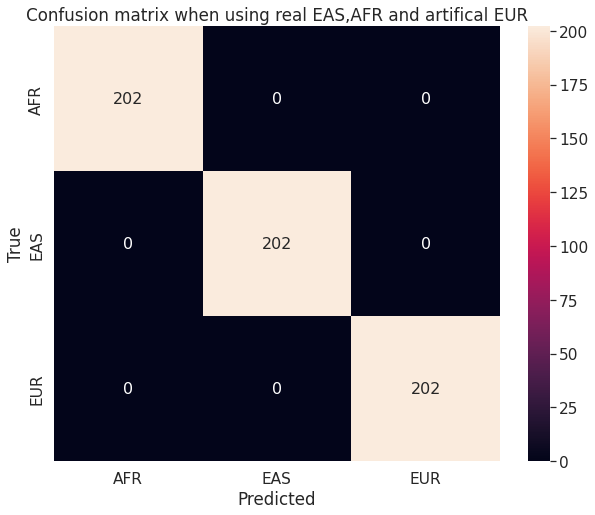

In [49]:
# creating and visualizing the confusion matrix
labs = np.unique(pred_df[['Population', 'Prediction']])
cm = confusion_matrix(pred_df.Population, pred_df.Prediction, labels=labs)
cm_plot = plot_cm(cm,title='Confusion matrix when using real EAS,AFR and artifical EUR', normalize=False, labels=labs)
cm_plot.figure.savefig(f'{output_basename}confusion_matrix.png')

If you want to visualize population SNP on the chromosome.